In [1]:
import os
import numpy as np
import json
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib
import librosa
import matplotlib.pyplot as plt

In [2]:
# Load Data
if os.path.exists('w_noise_data.joblib') and os.path.exists('w_noise_labels.joblib'):
    data = joblib.load('w_noise_data.joblib')
    labels = joblib.load('w_noise_labels.joblib')
else:
    print("Error: Data files not found.")
    exit()

In [3]:
# Convert labels to numerical values
label_dict = {label: idx for idx, label in enumerate(set(labels))}
numeric_labels = np.array([label_dict[label] for label in labels])
X = np.array(data)
y = np.array(numeric_labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Load data and labels
# data = joblib.load('data.joblib')
# labels = joblib.load('labels.joblib')

# # Convert labels to numerical values
# label_dict = {label: idx for idx, label in enumerate(set(labels))}
# numeric_labels = np.array([label_dict[label] for label in labels])

# # Split data into train and test sets
# X = np.array(data)
# y = np.array(numeric_labels)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Convert labels to one-hot encoding
# y_train_onehot = to_categorical(y_train)
# y_test_onehot = to_categorical(y_test)

In [4]:
from tabulate import tabulate

# Counting samples per genre in training set
train_genre_counts = {label: np.sum(y_train == idx) for label, idx in label_dict.items()}

# Counting samples per genre in testing set
test_genre_counts = {label: np.sum(y_test == idx) for label, idx in label_dict.items()}

# Convert counts to a list of lists for tabulate
table_data = []

for label, count in train_genre_counts.items():
    table_data.append([label, count, test_genre_counts[label]])

# Headers for the table
headers = ["Genre", "Training Samples", "Testing Samples"]

# Print the table
print("Training and Testing Set Samples per Genre:")
print(tabulate(table_data, headers=headers, tablefmt="grid"))

Training and Testing Set Samples per Genre:
+-----------+--------------------+-------------------+
| Genre     |   Training Samples |   Testing Samples |
+===========+====================+===================+
| pop       |                691 |               309 |
+-----------+--------------------+-------------------+
| blues     |                701 |               299 |
+-----------+--------------------+-------------------+
| disco     |                683 |               317 |
+-----------+--------------------+-------------------+
| classical |                681 |               319 |
+-----------+--------------------+-------------------+
| metal     |                693 |               307 |
+-----------+--------------------+-------------------+
| reggae    |                713 |               287 |
+-----------+--------------------+-------------------+
| hiphop    |                705 |               295 |
+-----------+--------------------+-------------------+
| country   |        

In [5]:
def build_cnn_model(input_shape, filters=32, kernel_size=3, dropout_rate=0.3, l2_reg=0.001):
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())  # Pooling after the first convolutional layer
    model.add(Conv1D(filters, kernel_size, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D(filters*4, kernel_size, activation='relu'))  # Added third convolutional layer
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(len(label_dict), activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

baseline_cnn_model = build_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

baseline_cnn_history = baseline_cnn_model.fit(
        X_train_cnn, y_train_onehot, 
        epochs=30, batch_size=32, 
        validation_data=(X_test_cnn, y_test_onehot)
    )

# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(baseline_cnn_history.history['accuracy']) + 1
max_train_accuracy = np.max(baseline_cnn_history.history['accuracy'])
corresponding_val_accuracy = baseline_cnn_history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(baseline_cnn_history.history['loss']) + 1
min_train_loss = np.min(baseline_cnn_history.history['loss'])
corresponding_val_loss = baseline_cnn_history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
test_loss, test_accuracy = baseline_cnn_model.evaluate(X_test_cnn, y_test_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")




Epoch 1/30


241/241 [==============================] - 4s 9ms/step - loss: 2.1225 - accuracy: 0.2769 - val_loss: 1.9117 - val_accuracy: 0.4361
Epoch 2/30
241/241 [==============================] - 2s 7ms/step - loss: 1.6800 - accuracy: 0.4335 - val_loss: 1.4809 - val_accuracy: 0.5370
Epoch 3/30
241/241 [==============================] - 2s 7ms/step - loss: 1.4893 - accuracy: 0.5013 - val_loss: 1.3372 - val_accuracy: 0.5618
Epoch 4/30
241/241 [==============================] - 2s 7ms/step - loss: 1.4026 - accuracy: 0.5292 - val_loss: 1.2714 - val_accuracy: 0.5848
Epoch 5/30
241/241 [==============================] - 2s 7ms/step - loss: 1.3372 - accuracy: 0.5518 - val_loss: 1.2007 - val_accuracy: 0.6118
Epoch 6/30
241/241 [==============================] - 2s 8ms/step - loss: 1.2843 - accuracy: 0.5682 - val_loss: 1.1828 - val_accuracy: 0.6100
Epoch 7/30
241/241 [==============================] - 2s 7ms/step - loss: 1.2411 - accuracy: 0.5770 - val_loss: 1.1326 - val_accuracy: 0.6233
Ep

In [6]:
print(baseline_cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 36, 32)            128       
                                                                 
 batch_normalization (Batch  (None, 36, 32)            128       
 Normalization)                                                  
                                                                 
 max_pooling1d (MaxPooling1  (None, 18, 32)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 32)            3104      
                                                                 
 batch_normalization_1 (Bat  (None, 16, 32)            128       
 chNormalization)                                                
                                                        

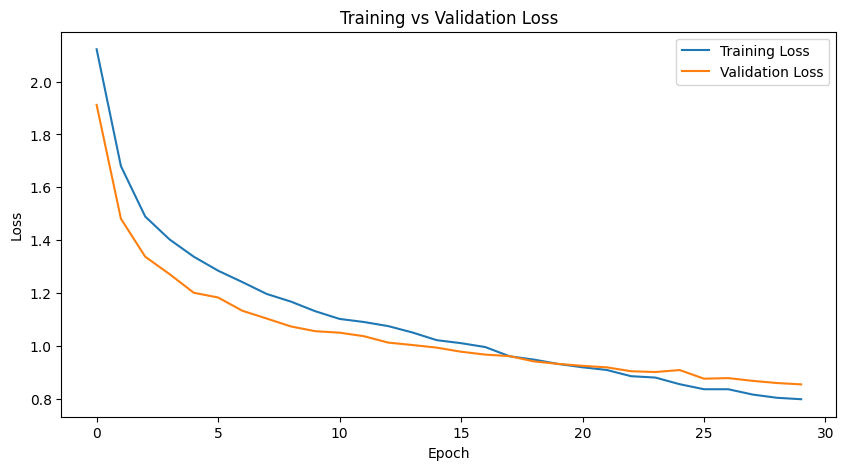

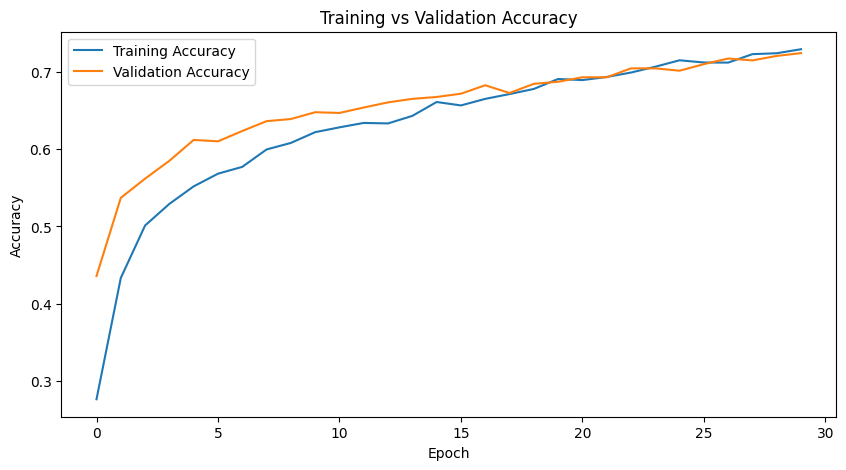

104/104 [==============================] - 0s 3ms/step - loss: 0.8539 - accuracy: 0.7239
Highest Training Accuracy: 0.7290 at Epoch 30, Validation Accuracy: 0.7239
Minimum Training Loss: 0.7978 at Epoch 30, Validation Loss: 0.8539
Test Accuracy: 72.39%


In [7]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(baseline_cnn_history.history['loss'], label='Training Loss')
plt.plot(baseline_cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(baseline_cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(baseline_cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(baseline_cnn_history.history['accuracy']) + 1
max_train_accuracy = np.max(baseline_cnn_history.history['accuracy'])
corresponding_val_accuracy = baseline_cnn_history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(baseline_cnn_history.history['loss']) + 1
min_train_loss = np.min(baseline_cnn_history.history['loss'])
corresponding_val_loss = baseline_cnn_history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
test_loss, test_accuracy = baseline_cnn_model.evaluate(X_test_cnn, y_test_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


104/104 [==============================] - 0s 3ms/step


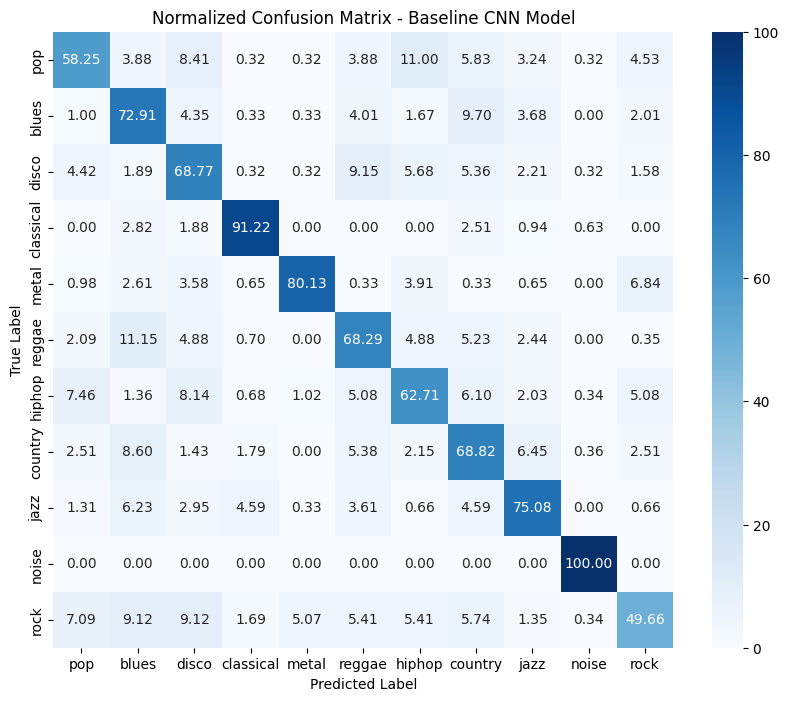

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred_baseline = np.argmax(baseline_cnn_model.predict(X_test_cnn), axis=1)

# Compute confusion matrix for the baseline CNN model
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)

# Convert confusion matrix to percentages
conf_matrix_baseline_norm = conf_matrix_baseline.astype('float') / conf_matrix_baseline.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix for the baseline CNN model
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_baseline_norm, annot=True, fmt='.2f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Normalized Confusion Matrix - Baseline CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [9]:
from sklearn.metrics import classification_report

# Predictions for test data
y_pred = np.argmax(baseline_cnn_model.predict(X_test_cnn), axis=1)

# Convert one-hot encoded labels back to original labels
y_test_labels = np.argmax(y_test_onehot, axis=1)

# Calculate precision, recall, and F1-score
cnn_report = classification_report(y_test_labels, y_pred)

# Print the classification report
print("CNN Metrics:")
print(cnn_report)


104/104 [==============================] - 0s 3ms/step
CNN Metrics:
              precision    recall  f1-score   support

           0       0.69      0.58      0.63       309
           1       0.61      0.73      0.66       299
           2       0.62      0.69      0.65       317
           3       0.90      0.91      0.91       319
           4       0.92      0.80      0.86       307
           5       0.64      0.68      0.66       287
           6       0.63      0.63      0.63       295
           7       0.58      0.69      0.63       279
           8       0.77      0.75      0.76       305
           9       0.98      1.00      0.99       287
          10       0.67      0.50      0.57       296

    accuracy                           0.72      3300
   macro avg       0.73      0.72      0.72      3300
weighted avg       0.73      0.72      0.72      3300



In [870]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
def build_cnn_model(input_shape, filters=64, kernel_size=3, dropout_rate=0.6, l2_reg=0.001):  # Modified dropout_rate and l2_reg
    model = Sequential()
    model.add(Conv1D(filters, kernel_size, padding='same', activation='relu', input_shape=input_shape, kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Conv1D(filters * 4, kernel_size, padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D())

    model.add(Flatten())
    model.add(Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_reg)))
    model.add(Dropout(dropout_rate))  # Increased dropout_rate
    model.add(Dense(len(label_dict), activation='softmax'))  

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

cnn_model = build_cnn_model(input_shape=(X_train_cnn.shape[1], 1))

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=1.5, restore_best_weights=True)  # Increased patience
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=1, 
    min_lr=0.00001
)

# Fit the model with modified parameters
history = cnn_model.fit(
    X_train_cnn, y_train_onehot, epochs=30, batch_size=32,
    validation_data=(X_test_cnn, y_test_onehot),
    callbacks=[early_stopping, reduce_lr]
)
# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(cnn_model.history.history['accuracy']) + 1
max_train_accuracy = np.max(cnn_model.history.history['accuracy'])
corresponding_val_accuracy = cnn_model.history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(cnn_model.history.history['loss']) + 1
min_train_loss = np.min(cnn_model.history.history['loss'])
corresponding_val_loss = cnn_model.history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")



Epoch 1/30
241/241 [==============================] - 16s 59ms/step - loss: 3.1792 - accuracy: 0.4082 - val_loss: 3.0553 - val_accuracy: 0.4624 - lr: 1.0000e-04
Epoch 2/30
241/241 [==============================] - 30s 126ms/step - loss: 2.7714 - accuracy: 0.4995 - val_loss: 2.6341 - val_accuracy: 0.5615 - lr: 1.0000e-04
Epoch 3/30
241/241 [==============================] - 25s 102ms/step - loss: 2.5990 - accuracy: 0.5377 - val_loss: 2.4557 - val_accuracy: 0.5821 - lr: 1.0000e-04
Epoch 4/30
241/241 [==============================] - 13s 53ms/step - loss: 2.4722 - accuracy: 0.5625 - val_loss: 2.3187 - val_accuracy: 0.6188 - lr: 1.0000e-04
Epoch 5/30
241/241 [==============================] - 12s 52ms/step - loss: 2.3497 - accuracy: 0.5947 - val_loss: 2.2212 - val_accuracy: 0.6279 - lr: 1.0000e-04
Epoch 6/30
241/241 [==============================] - 18s 73ms/step - loss: 2.2369 - accuracy: 0.6164 - val_loss: 2.1179 - val_accuracy: 0.6476 - lr: 1.0000e-04
Epoch 7/30
241/241 [============

KeyboardInterrupt: 

In [ ]:
print(cnn_model.summary())
# cnn_model.save( 'test_cnn_model.h5')

Model: "sequential_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_252 (Conv1D)         (None, 38, 64)            256       
                                                                 
 batch_normalization_251 (B  (None, 38, 64)            256       
 atchNormalization)                                              
                                                                 
 max_pooling1d_241 (MaxPool  (None, 19, 64)            0         
 ing1D)                                                          
                                                                 
 conv1d_253 (Conv1D)         (None, 19, 256)           49408     
                                                                 
 batch_normalization_252 (B  (None, 19, 256)           1024      
 atchNormalization)                                              
                                                     

In [ ]:
cnn_predictions = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

improved_cnn_accuracy = accuracy_score(y_test, cnn_predictions)
print(f"CNN Model Accuracy: {improved_cnn_accuracy}")

104/104 [==============================] - 2s 19ms/step
CNN Model Accuracy: 0.7533333333333333


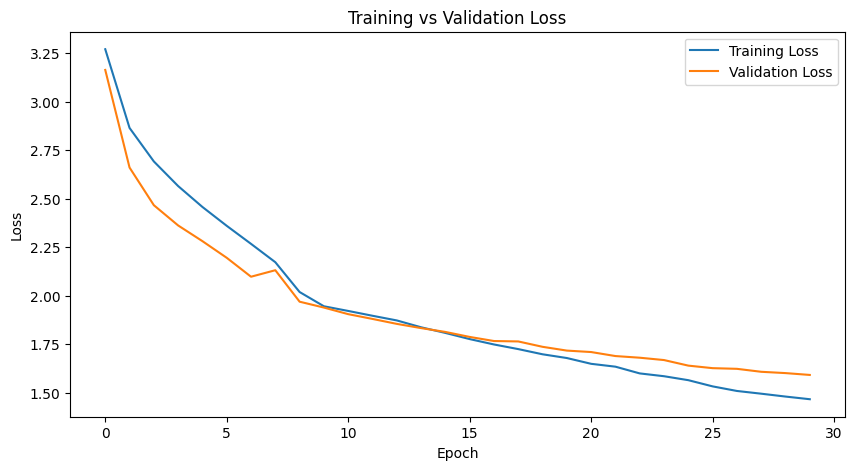

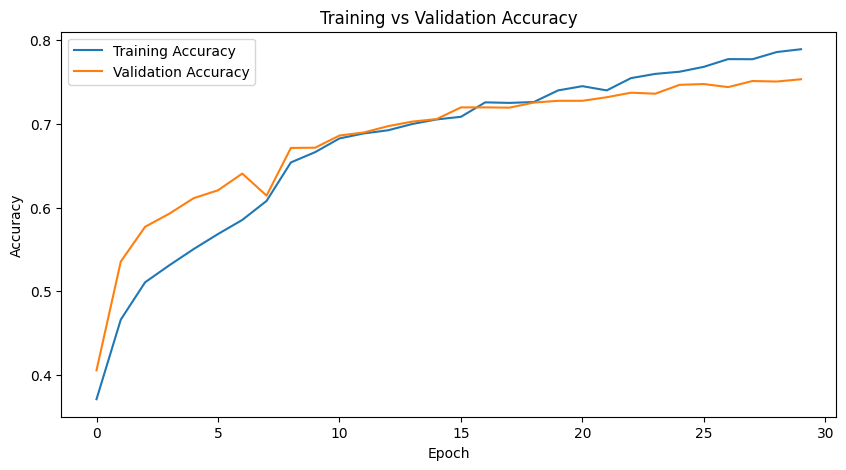

104/104 [==============================] - 2s 18ms/step - loss: 1.5925 - accuracy: 0.7533
Highest Training Accuracy: 0.7892 at Epoch 30, Validation Accuracy: 0.7533
Minimum Training Loss: 1.4675 at Epoch 30, Validation Loss: 1.5925
Test Accuracy: 75.33%


In [ ]:
import matplotlib.pyplot as plt

# Plot training vs validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training vs validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Find the epoch with the highest training accuracy and corresponding validation accuracy
max_train_accuracy_epoch = np.argmax(history.history['accuracy']) + 1
max_train_accuracy = np.max(history.history['accuracy'])
corresponding_val_accuracy = history.history['val_accuracy'][max_train_accuracy_epoch - 1]

# Find the epoch with the minimum training loss and corresponding validation loss
min_train_loss_epoch = np.argmin(history.history['loss']) + 1
min_train_loss = np.min(history.history['loss'])
corresponding_val_loss = history.history['val_loss'][min_train_loss_epoch - 1]

# Calculate test accuracy
test_loss, test_accuracy = cnn_model.evaluate(X_test_cnn, y_test_onehot)

# Print the results
print(f"Highest Training Accuracy: {max_train_accuracy:.4f} at Epoch {max_train_accuracy_epoch}, Validation Accuracy: {corresponding_val_accuracy:.4f}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at Epoch {min_train_loss_epoch}, Validation Loss: {corresponding_val_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2%}")


104/104 [==============================] - 1s 14ms/step


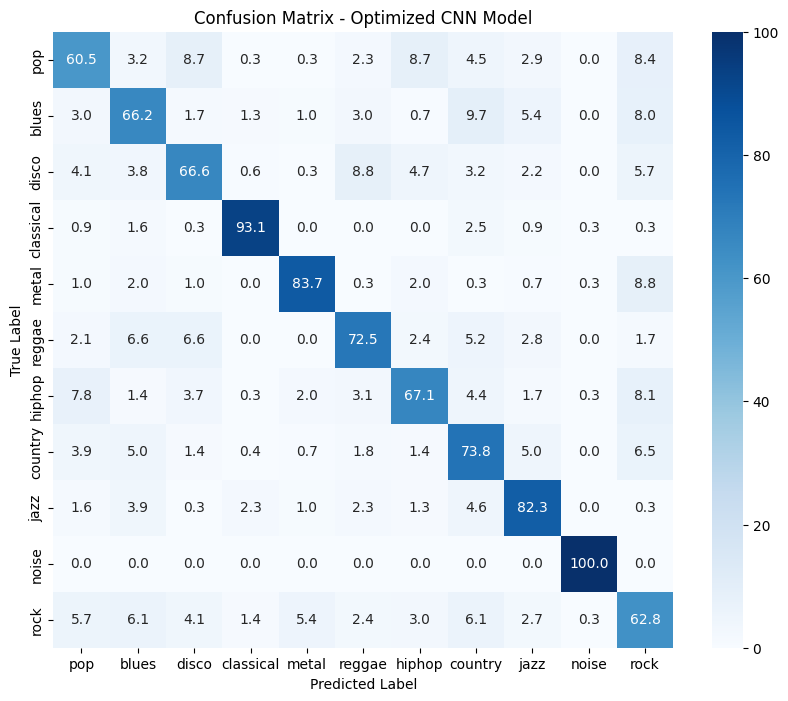

In [ ]:
y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Compute confusion matrix with percentages
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Confusion Matrix - Optimized CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# cnn_features to extract to svm and random forest
cnn_features_train = cnn_model.predict(X_train_cnn)
cnn_features_test = cnn_model.predict(X_test_cnn)

from sklearn.preprocessing import StandardScaler

# Scale CNN features for SVM
scaler = StandardScaler()
cnn_features_train_scaled = scaler.fit_transform(cnn_features_train)
cnn_features_test_scaled = scaler.transform(cnn_features_test)

# svm_model = SVC(kernel='rbf', C=1.0, gamma='auto').fit(cnn_features_train_scaled, y_train)

# Train SVM model
svm_model = SVC()
param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf', 'poly'], 'gamma': [0.1, 1, 'auto']}
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=3, scoring='accuracy')
svm_model.fit(cnn_features_train_scaled, y_train)
svm_predictions = svm_model.predict(cnn_features_test_scaled)

# Train Random Forest model with the same scaled features
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,  # Increase max_depth
    min_samples_split=10,  # Increase min_samples_split
    min_samples_leaf=5,  # Increase min_samples_leaf
    random_state=42
)

# Train the Random Forest model
rf_model.fit(cnn_features_train_scaled, y_train)

# Predictions for SVM and Random Forest
svm_predictions = svm_model.predict(cnn_features_test_scaled)
rf_predictions = rf_model.predict(cnn_features_test_scaled)

print("SVM Prediction: ", svm_predictions)
print("Random Forest Prediction: ", rf_predictions)
print("Random Forest Confidence Levels: ", rf_model.predict_proba(cnn_features_test_scaled))


ensemble_input = np.column_stack((svm_predictions, rf_predictions, np.argmax(cnn_model.predict(X_test_cnn), axis=1)))

xgb_model = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1).fit(ensemble_input, y_test)

# ensemble_predictions = xgb_model.predict(ensemble_input)
# ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

# Evaluate the models
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(ensemble_input))


print(f"SVM Model Accuracy: {svm_accuracy:.4f}")
print(f"Random Forest Model Accuracy: {rf_accuracy:.4f}")
print(f"XGBoost Model Accuracy: {xgb_accuracy:.4f}")

104/104 [==============================] - 4s 39ms/step
SVM Prediction:  [10  8  4 ...  4  7 10]
Random Forest Prediction:  [10  8  4 ...  4  7 10]
Random Forest Confidence Levels:  [[5.16341447e-02 1.01418924e-02 1.48371101e-02 ... 0.00000000e+00
  0.00000000e+00 5.71298272e-01]
 [1.92307692e-03 7.84547860e-03 1.27492877e-03 ... 9.73214605e-01
  0.00000000e+00 4.08369408e-03]
 [1.03174603e-03 0.00000000e+00 8.33333333e-04 ... 0.00000000e+00
  0.00000000e+00 5.44576339e-03]
 ...
 [6.36033914e-02 3.49176083e-02 1.10122502e-01 ... 9.95726496e-03
  0.00000000e+00 1.31270799e-01]
 [4.41501104e-05 1.22060465e-03 8.33333333e-04 ... 5.55555556e-04
  0.00000000e+00 9.90778559e-04]
 [1.15995671e-03 1.15440115e-03 4.32900433e-05 ... 0.00000000e+00
  0.00000000e+00 9.80886319e-01]]
104/104 [==============================] - 5s 47ms/step
SVM Model Accuracy: 0.7582
Random Forest Model Accuracy: 0.7579
XGBoost Model Accuracy: 0.7670


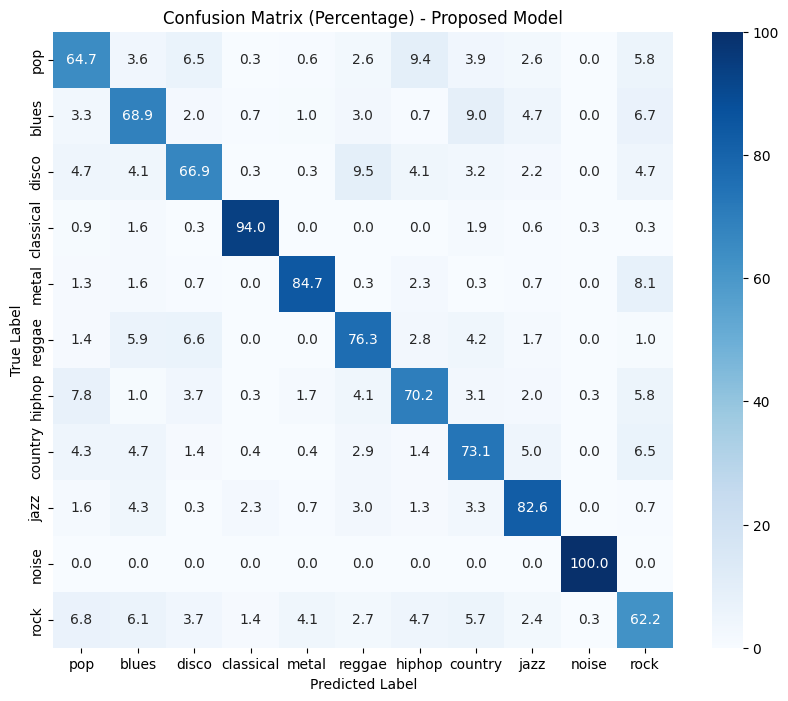

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predictions for the ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)

# Compute confusion matrix for ensemble predictions
conf_matrix_ensemble = confusion_matrix(y_test, ensemble_predictions)

# Compute confusion matrix with percentages for ensemble predictions
conf_matrix_ensemble_percentage = conf_matrix_ensemble.astype('float') / conf_matrix_ensemble.sum(axis=1)[:, np.newaxis] * 100

# Plot confusion matrix with percentages for ensemble predictions
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_ensemble_percentage, annot=True, fmt='.1f', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.title('Confusion Matrix (Percentage) - Proposed Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Predictions for ensemble model
ensemble_predictions = xgb_model.predict(ensemble_input)

# Calculate precision, recall, F1-score, and accuracy for the ensemble model
ensemble_report = classification_report(y_test, ensemble_predictions)
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)

print("Proposed Model Metrics:")
print(ensemble_report)
print("Proposed Model Accuracy:", ensemble_accuracy)


Proposed Model Metrics:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66       309
           1       0.68      0.69      0.68       299
           2       0.74      0.67      0.70       317
           3       0.95      0.94      0.94       319
           4       0.91      0.85      0.88       307
           5       0.72      0.76      0.74       287
           6       0.72      0.70      0.71       295
           7       0.66      0.73      0.70       279
           8       0.79      0.83      0.81       305
           9       0.99      1.00      0.99       287
          10       0.61      0.62      0.61       296

    accuracy                           0.77      3300
   macro avg       0.77      0.77      0.77      3300
weighted avg       0.77      0.77      0.77      3300

Proposed Model Accuracy: 0.766969696969697


In [ ]:
saved_folder = 'files_w_noise'

# Create the folder if it doesn't exist
if not os.path.exists(saved_folder):
    os.makedirs(saved_folder)

# Save models
joblib.dump(xgb_model, os.path.join(saved_folder, 'xgb_model.joblib'))
joblib.dump(svm_model, os.path.join(saved_folder, 'svm_model.joblib'))
joblib.dump(rf_model, os.path.join(saved_folder, 'rf_model.joblib'))
# Save CNN model
cnn_model.save(os.path.join(saved_folder, 'cnn_model.h5'))
baseline_cnn_model.save(os.path.join(saved_folder, 'baseline_cnn_model.h5'))


# Save data arrays
np.save(os.path.join(saved_folder, 'ensemble_input.npy'), ensemble_input)
np.save(os.path.join(saved_folder, 'y_test.npy'), y_test)
np.save(os.path.join(saved_folder, 'X_test.npy'), X_test)
np.save(os.path.join(saved_folder, 'X_test_cnn.npy'), X_test_cnn)

# Save label dictionary
with open(os.path.join(saved_folder, 'label_dict_2.json'), 'w') as json_file:
    json.dump(label_dict, json_file)


c:\laragon\bin\python\python-3.10\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# saved_folder = 'saved_folder'

# # Create the folder if it doesn't exist
# if not os.path.exists(saved_folder):
#     os.makedirs(saved_folder)

# # Save models
# joblib.dump(xgb_model, os.path.join(saved_folder, 'xgb_model.joblib'))
# joblib.dump(svm_model, os.path.join(saved_folder, 'test_svm_model.joblib'))
# joblib.dump(rf_model, os.path.join(saved_folder, 'test_rf_model.joblib'))
# # Save CNN model
# cnn_model.save(os.path.join(saved_folder, 'test_cnn_model.h5'))

# # Save data arrays
# np.save(os.path.join(saved_folder, 'ensemble_input.npy'), ensemble_input)
# np.save(os.path.join(saved_folder, 'y_test.npy'), y_test)
# np.save(os.path.join(saved_folder, 'X_test.npy'), X_test)
# np.save(os.path.join(saved_folder, 'X_test_cnn.npy'), X_test_cnn)

# # Save label dictionary
# with open(os.path.join(saved_folder, 'label_dict.json'), 'w') as json_file:
#     json.dump(label_dict, json_file)


In [ ]:
from tensorflow.keras.models import load_model

# cnn_model = load_model('test_cnn_model.h5')

def extract_features(file_path):
    try:
        # Load MP3 file
        audio, _ = librosa.load(file_path, sr=22050, mono=True)  # Adjust duration as needed
        mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=13)
        chroma = librosa.feature.chroma_stft(y=audio, sr=22050)
        spectral_contrast = librosa.feature.spectral_contrast(y=audio, sr=22050)
        tonnetz = librosa.feature.tonnetz(y=audio, sr=22050)
        features = np.vstack([mfccs, chroma, spectral_contrast, tonnetz])
        mean_features = np.mean(features.T, axis=0)
        return mean_features
    except Exception as e:
        print(f"Error encountered while parsing file '{file_path}': {e}")
        return None
    
saved_folder = 'files_w_noise'

# Load data and models from the saved folder
y_test = np.load(os.path.join(saved_folder, 'y_test.npy'))
cnn_model = load_model(os.path.join(saved_folder, 'cnn_model.h5'))
baseline_cnn_model = load_model(os.path.join(saved_folder, 'baseline_cnn_model.h5'))

rf_model = joblib.load(os.path.join(saved_folder, 'rf_model.joblib'))
svm_model = joblib.load(os.path.join(saved_folder, 'svm_model.joblib'))
xgb_model = joblib.load(os.path.join(saved_folder, 'xgb_model.joblib'))
# Load label dictionary
with open(os.path.join(saved_folder, 'label_dict_2.json'), 'r') as json_file:
    label_dict = json.load(json_file)
    
    # sample_features = extract_features('..\\Data\\genres_original\\metal\\metal.00000.wav')
    # sample_features = extract_features('ocean.wav')
    sample_features = extract_features('classical.wav')
    # sample_features = extract_features('ocean.wav')

sample_features_cnn = sample_features.reshape(1, sample_features.shape[0], 1)
# Use the CNN model to predict the genre probabilities
cnn_prediction_prob = baseline_cnn_model.predict(sample_features_cnn)[0]
# Map the numerical labels to genre names
genre_names = {idx: genre for genre, idx in label_dict.items()}
# Create a dictionary to store predicted percentages for each class
predicted_percentages = {}
# Loop through each class and store the predicted percentage
for idx, genre_prob in enumerate(cnn_prediction_prob):
    genre_name = genre_names[idx]
    predicted_percentages[genre_name] = float(genre_prob) * 100
# Get the predicted genre with the highest probability
predicted_genre = max(predicted_percentages, key=predicted_percentages.get)
# Create a dictionary for the JSON result
json_result_cnn = {
    "Predicted Genre (Baseline)": predicted_genre,
    "Predicted Percentages (Baseline)": predicted_percentages
}

1/1 [==============================] - 1s 716ms/step


In [ ]:
cnn_features_sample = cnn_model.predict(sample_features_cnn)
# Make predictions using SVM and Random Forest models
svm_prediction_sample = svm_model.predict(cnn_features_sample)
rf_prediction_sample = rf_model.predict(cnn_features_sample)
# Ensemble predictions
ensemble_input_sample = np.column_stack((svm_prediction_sample, rf_prediction_sample, np.argmax(cnn_prediction_prob)))
# ensemble_input_sample = np.column_stack((svm_prediction_sample,svm_prediction_sample,rf_prediction_sample, np.argmax(cnn_prediction_prob)))

# Train an XGBoost model on the ensemble predictions
xgb_model_ensemble = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
xgb_model_ensemble.fit(ensemble_input, y_test)
# Make predictions using the ensemble XGBoost model
ensemble_prediction_sample = xgb_model_ensemble.predict(ensemble_input_sample)
# Get the predicted genre with the highest probability
predicted_genre_ensemble = genre_names[ensemble_prediction_sample[0]]
# Get the predicted probabilities for each genre
predicted_probabilities_ensemble = xgb_model_ensemble.predict_proba(ensemble_input_sample)[0]

# Find the maximum probability
max_probability = max(predicted_probabilities_ensemble)

# Check if the maximum probability is greater than 0.5
if max_probability > 0.5:
    # Get the index of the maximum probability
    max_index = np.argmax(predicted_probabilities_ensemble)
    
    # Get the predicted genre with the highest probability
    predicted_genre_ensemble = genre_names[max_index]
else:
    # Set the predicted genre as "undefined"
    predicted_genre_ensemble = "Cannot Classify the Audio"

# Create a dictionary to store predicted percentages for each class
predicted_percentages_ensemble = {}

# Loop through each genre and its corresponding probability
for genre, percentage in zip(genre_names.values(), predicted_probabilities_ensemble):
    predicted_percentages_ensemble[genre] = float(percentage) * 100

# Create a dictionary for the JSON result
json_result_ensemble = {
    "Predicted Genre (Optimized)": predicted_genre_ensemble,
    "Predicted Percentages (Optimized)": predicted_percentages_ensemble
}

1/1 [==============================] - 1s 665ms/step


In [ ]:
print(json.dumps(json_result_cnn, indent=4))
print(json.dumps(json_result_ensemble, indent=4))

{
    "Predicted Genre (Baseline)": "classical",
    "Predicted Percentages (Baseline)": {
        "pop": 0.555728655308485,
        "blues": 35.754191875457764,
        "disco": 0.36026311572641134,
        "classical": 51.609545946121216,
        "metal": 0.026998197427019477,
        "reggae": 7.868322730064392,
        "hiphop": 0.896594300866127,
        "country": 1.2198126874864101,
        "jazz": 1.0184578597545624,
        "noise": 0.6135071627795696,
        "rock": 0.0765848730225116
    }
}
{
    "Predicted Genre (Optimized)": "classical",
    "Predicted Percentages (Optimized)": {
        "pop": 0.35059929359704256,
        "blues": 0.681570265442133,
        "disco": 0.5694751627743244,
        "classical": 94.38516497612,
        "metal": 0.10373855475336313,
        "reggae": 0.25342819280922413,
        "hiphop": 0.5317992996424437,
        "country": 0.3782583633437753,
        "jazz": 1.523375604301691,
        "noise": 0.01898954651551321,
        "rock": 1.2036059